## this notebook use google colab

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Installing Required Packages

In [0]:
!pip install --upgrade gensim

## Imports

In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

# Reading Drive Files

In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
train_file_id = 0
test_file_id=0
for file1 in file_list:
  if file1['title'] == 'train.csv':
    train_file_id = file1['id']
  elif file1['title'] == 'test.csv':
    test_file_id=file1['id']

In [0]:
train = drive.CreateFile({'id': train_file_id})
train.GetContentFile('train.csv')

test = drive.CreateFile({'id': test_file_id})
test.GetContentFile('test.csv')

## Reading datasets

In [0]:
import io 

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [0]:
test_df = test_df.iloc[0:2345796,:]

## remove noise

In [0]:
import nltk
nltk.download('stopwords')

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Embeddings

## Building Vocab

In [0]:
from gensim.test.utils import datapath

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

EMBEDDING_FILE = datapath("euclidean_vectors.bin")
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

In [0]:
# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)

In [0]:
train_df.to_csv('train_list.csv', header=list(train_df), index=False)
test_df.to_csv('test_list.csv', header=list(test_df), index=False)

## Saving Vocab

In [0]:
f = open('vocabulary.txt','w')
f.write(str(vocabulary))
f.close()

''' Later Reading
f = open('vocabulary.txt','r')
vocabulary = f.read()
f.close()
'''

## Embedding Matrix

In [0]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        try:
            embeddings[index] = word2vec.word_vec(word)
        except:
            pass
          
del word2vec

## Data Preparation for Keras LSTM Model

In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding; for later input layer shape
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

assert X_test['left'].shape == X_test['right'].shape

# model: method for LSTM 

## Hyperparameters

In [0]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 8

## Similarity Measure

In [0]:
# Helper function for the similarity estimate of the LSTMs outputs
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

## Building

In [0]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

## Training

In [0]:
from google.colab import files

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# early stopping
#earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0002, patience=1, verbose=1, mode='auto')

# checkpoint
#filepath="model.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#callbacks_list = [checkpoint]

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

# Plots

## Accuracy

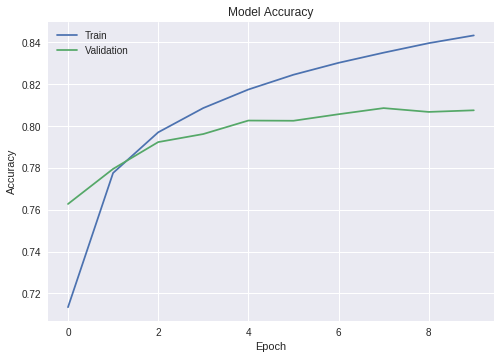

In [22]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Loss

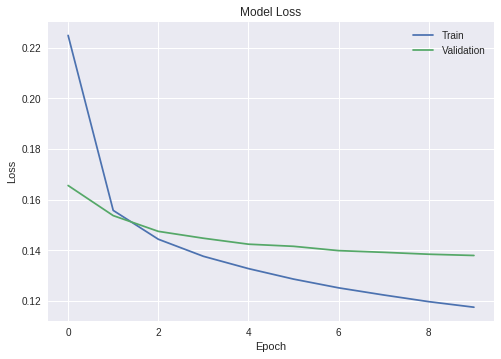

In [23]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Saving (equivalent to the Check Point effect)

In [0]:
malstm.save('trained_model.h5')

## Loading

In [0]:
from keras.models import load_model

model = load_weights('final_weights.hdf5')
# model = load_model('weights.hdf5', custom_objects={'exponent_neg_manhattan_distance': exponent_neg_manhattan_distance(left, right)})

# Prediction

In [0]:
prediction = malstm.predict([X_test['left'], X_test['right']], verbose=1)

## Saving Predictions

In [0]:
np.savetxt('predictions.txt', prediction)

## Loading Predictions

In [0]:
predict = np.loadtxt('predict.txt')

## Preparing Kaggle Submission File

In [0]:
#submission = pd.DataFrame(data={'test_id': np.arange(len(prediction)), 'is_duplicate': np.squeeze(prediction)}) # squeeze to convert to one-dimensional # not preserving order

data = {'test_id': np.arange(len(prediction)), 'is_duplicate': np.squeeze(prediction)} # squeeze to convert to one-dimensional
submission = pd.DataFrame(data, columns=data.keys()) # preserving order

In [0]:
submission.to_csv('submission.csv', header=list(submission), index=False)